In [5]:
import sys 
sys.path.append("OPM_lab")

import numpy as np
import matplotlib.pyplot as plt

from OPM_lab.sensor_locations import HelmetTemplate, FL_alpha1_helmet

In [21]:
def make_sensor_reference_layout(template:HelmetTemplate, channel_names, Z):
    """
    Create a sensor reference layout based on a helmet template and specified channels.

    Args:
        template (HelmetTemplate): The helmet template containing sensor information.
        channel_names (list of str): Names of the locations actually used for the sensors.
        Z (list of numeric): The z measurements of the channels used.

    Returns:
        OPMSensorLayout: The layout of the OPM sensors.
    """
    assert len(channel_names) == len(Z)

    # get indices of the channels used in the helmet template
    idx = [i for i, template_sens in enumerate(template.label) if template_sens in channel_names]
    template_pos = template.chan_pos[idx]
    template_ori = template.chan_ori[idx]

    print(template_pos)
    print(template_ori)

    # move the template_pos z in template ori to get the OPM pos

    # return OPMSensorLayout(OPM_ori, OPM_pos, channel_names)


make_sensor_reference_layout(FL_alpha1_helmet, channel_names= ["FL3", "FL10", "FL16"], Z = [0.03, 0.05, 0.01])


[[-0.03950802  0.12987231  0.00702394]
 [-0.06269032  0.1108322  -0.00455   ]
 [-0.08264246  0.08189714 -0.01993   ]]
[[-0.51169002  0.85434997  0.09093   ]
 [-0.74603999  0.66589999  0.        ]
 [-0.89486998  0.44633001  0.        ]]


ValueError: too many values to unpack (expected 3)

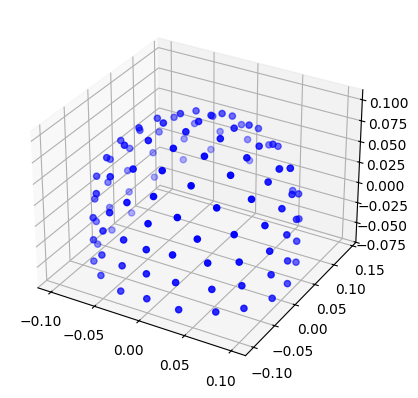

In [19]:




%matplotlib inline 
idx = [2, 3, 4]
template_pos_before = FL_alpha1_helmet.chan_pos
template_ori_before = FL_alpha1_helmet.chan_ori

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot_pos_ori(template_pos_before, template_ori_before, ax)

# ADD PLOTTING AFTER!!!

# Labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

plt.title('3D Plot of Template Positions and Orientations')
plt.show()

In [23]:
import mne
from pathlib import Path

path = Path("/Volumes/untitled/opm_cerebell/20221003/SD/")
opm_path = path / "20221003_151904_SD_opm_cerebell_passive_omission_raw.fif"
raw = mne.io.read_raw(opm_path, preload=True)

raw_old = raw.copy()

Opening raw data file /Volumes/untitled/opm_cerebell/20221003/SD/20221003_151904_SD_opm_cerebell_passive_omission_raw.fif...
Isotrak not found
    Range : 0 ... 1953850 =      0.000 ...  1953.850 secs
Ready.
Reading 0 ... 1953850  =      0.000 ...  1953.850 secs...


# WORKING ON GETTING DIG POINTS INTO MNE OBJECT

# ROTATION TRANSLATION NIGHTMARE



In [21]:
import sys 
sys.path.append("OPM_lab")

from OPM_lab.sensor_locations import FL_alpha1_helmet, HelmetTemplate, rot3dfit
import pandas as pd
from pathlib import Path
import mne

import numpy as np
import matplotlib.pyplot as plt

In [25]:

def add_dig_montage(mne_object, df:pd.DataFrame):
    fiducials = {}

    for label in ["nasion", "lpa", "rpa"]:
        fid = df[df["label"] == label].loc[:, ["x", "y", "z"]]
        fiducials[label] = np.array(fid).squeeze() / 100  # converting to meters!

    head_points = df[df["label"] == "head"].loc[:, ["x", "y", "z"]] / 100

    dig_montage = mne.channels.make_dig_montage(nasion=fiducials["nasion"], lpa=fiducials["lpa"], rpa=fiducials["rpa"], hsp=head_points, coord_frame='head')

    mne_object.info.set_montage(dig_montage)

class OPMSensorLayout:
    def __init__(self, label, depth, helmet_template:HelmetTemplate):
        self.label = label
        self.depth = depth
        self.helmet_template = helmet_template
        self.unit = self.helmet_template.unit
        
        self.make_sensor_layout()

    def make_sensor_layout(self):
        # Update template location given the depth measurement
        self.chan_pos = self.transform_template_depth()
        self.chan_ori = self.helmet_template.get_chs_ori(self.label)
    
    def transform_template_depth(self, len_sleeve:float = 75/1000, offset:float = 13/1000): #len_sleeve:float = 75/1000, offset:float = 13/1000
        template_ori = self.helmet_template.get_chs_ori(self.label)
        template_pos = self.helmet_template.get_chs_pos(self.label)
        
        # Create a new list to store the updated positions
        transformed_pos = []
        
        # Move template pos by measurement length in template ori direction
        for pos, ori, depth in zip(template_pos, template_ori, self.depth):
            # Update the position by adding the orientation scaled by the measurement
            new_pos = np.array(pos) + np.array(ori) * -(len_sleeve - (depth + offset))
            transformed_pos.append(new_pos)
        
        return np.array(transformed_pos).T


def update_OPM_pos(mne_object, df):    

    channels = df[df["sensor_type"] == "OPM"]
    coordinates = np.array(channels.loc[:, ["x", "y", "z"]]).squeeze()
    labels = channels["label"]

    for coor, label in zip(coordinates, labels):
        coor = coor / 100

        idx = None

        # Find the channel with the label in the info of the mne object
        for idx_tmp, ch in enumerate(mne_object.info["chs"]):
            mne_ch_name = ch["ch_name"]
            if mne_ch_name == label:
                idx = idx_tmp
                break

        # Update the location of that channel
        mne_object.info['chs'][idx]['loc'][:3] = coor

def plot_pos_ori(pos, ori, ax, label = "", c = "b"):

    # Plot positions
    ax.scatter(pos[0, :], pos[1, :], pos[2:], color=c, label=f'position {label}')

    # Plot orientations as arrows
    for i in range(pos.shape[-1]):
        x, y, z = pos[:, i]
        u, v, w = ori[i]
        
        ax.quiver(x, y, z, u, v, w, length=0.01, normalize=True, color=c, label=f'Orientation {label}' if i == 0 else "")
        # Simple representation of orientation using arrows (may need adjustments based on actual orientation representation)
        #ax.quiver(x, y, z, np.cos(yaw), np.sin(yaw), 0, length=0.02, color=c, label=f'Orientation {label}' if i == 0 else "")


In [26]:
path = Path("/Volumes/untitled/opm_cerebell/20221003/SD/")
opm_path = path / "20221003_151904_SD_opm_cerebell_passive_omission_raw.fif"
raw = mne.io.read_raw(opm_path, preload=True)

raw_old = raw.copy()
points = pd.read_csv("/Users/au661930/Library/CloudStorage/OneDrive-Aarhusuniversitet/Dokumenter/project placement/OPM_lab/output/test1_digitisation.csv")

depth_meas = [40/1000, 47/1000, 44/1000, 40/1000] # mm converted to meter (order = 3, 10, 16, 62)

sensor_layout = OPMSensorLayout(
        label=["FL3", "FL10", "FL16", "FL62"], 
        depth=depth_meas,
        helmet_template=FL_alpha1_helmet
        ) 

Opening raw data file /Volumes/untitled/opm_cerebell/20221003/SD/20221003_151904_SD_opm_cerebell_passive_omission_raw.fif...
Isotrak not found
    Range : 0 ... 1953850 =      0.000 ...  1953.850 secs
Ready.
Reading 0 ... 1953850  =      0.000 ...  1953.850 secs...


### CHECKING THAT UPDATING SENSOR TEMPLATE WITH DEPTH MEASUREMENT WORKS
Looks good

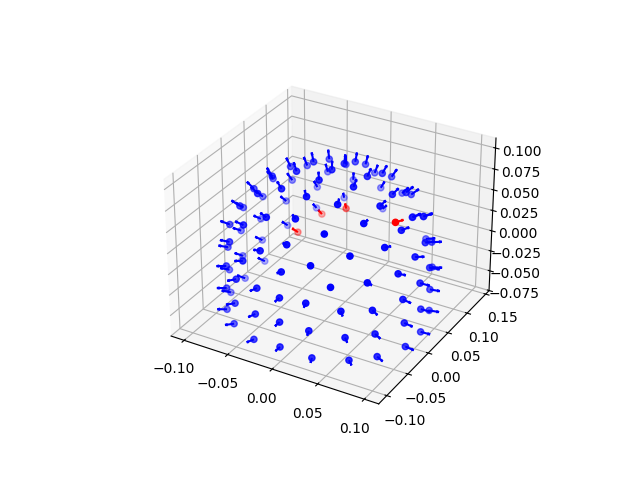

In [27]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



plot_pos_ori(FL_alpha1_helmet.chan_pos.T, FL_alpha1_helmet.chan_ori, ax=ax, label = "helmet template",)
plot_pos_ori(sensor_layout.chan_pos, sensor_layout.chan_ori, ax=ax, c="red")



In [ ]:

raw.pick(["00:01-BZ_CL", '00:02-BZ_CL', "00:03-BZ_CL", "00:04-BZ_CL"])

mne.rename_channels(raw.info, {"00:01-BZ_CL" : "FL3", 
                                "00:02-BZ_CL" : "FL10", 
                                "00:03-BZ_CL" : "FL16", 
                                "00:04-BZ_CL" : "FL62"})
    
    
add_dig_montage(raw, points)


### Checking that adding digmontage works

In [ ]:
update_OPM_pos(raw, points)
#update_OPM_ori(raw, sensor_layout)

    
#kwargs = dict(eeg=False, coord_frame="meg", show_axes=True, verbose=True, dig = True)
#fig = plot_alignment(raw.info, meg=("sensors"), **kwargs)